This Script is for Running longer simulations of a standar PBDE set up with their different States using probabilities without POC

In [359]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import pandas as pd
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [360]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [361]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Variable_Release',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}

In [362]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [363]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [364]:
#Definitions
start = datetime(2022, 1, 1) #Start date
length = 5 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 1 # 1000   # number of  locations
# Here the number of particles needs to be associated to the discharge rates from the Iona Outfall
n = 2000 # number of particles per location
dmin = 60#minimum depth
dd = 20 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [365]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(datetime(2022, 1, 1),path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [366]:
#Set deploy coordinates following yaml   
clat = [49.195045]
clon = [-123.301956]
#
a, b = finder(clat[0], clon[0])
print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
#
duration = timedelta(days=length)
#
x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)
#
lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

The total depth at this location is 85.375 m


In [367]:
# Files for states runs
name_states = 'Variable_particle_release_'+str(length)+'_days_' 
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration])# + '.zarr'
outfile_states = os.path.join(path['out'], fn)
#
local = 0

In [368]:
outfile_states

'/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Variable_Release/Variable_particle_release_5_days_20220101_1n_20220106_1n'

In [369]:
varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol','last_cell_index']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
density = Field.from_netcdf(filenames['R'], variables['R'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(density)
#
#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)
#
#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
MBATHY = Field.from_netcdf(filenames['last_cell_index'], variables['last_cell_index'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(MBATHY)
field_set.add_field(Bth)
field_set.add_field(TD)
#
#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)
#
# Add e3t
varlist = ['cell_size']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
E3T = Field.from_netcdf(filenames['cell_size'], variables['cell_size'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(E3T)
#

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded prope

In [370]:
data_PBDE = pd.read_excel('/ocean/vvalenzuela/MOAD/analysis-vicente/PBDEs_DATA/predicted_discharges.xlsx')
data_PBDE = data_PBDE.set_index(data_PBDE['Unnamed: 0'].values)
data_PBDE.drop('Unnamed: 0', axis=1, inplace=True)

In [371]:
PBDE_hourly = data_PBDE.resample('H').interpolate()
PBDE_daily = data_PBDE.copy()

In [372]:
data99_H = PBDE_hourly['PBDE 99']
data99_D = PBDE_daily['PBDE 99']

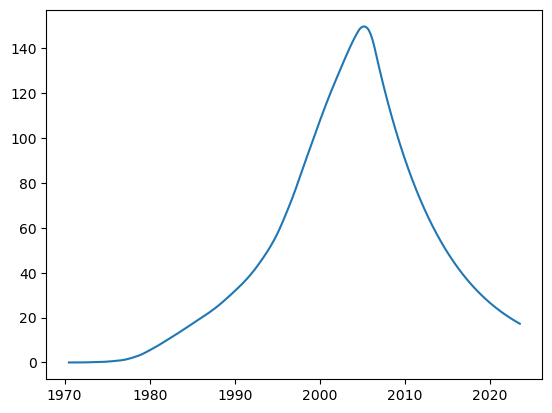

In [373]:
# Amount of particles that we want to release in time (just a test for now)
amount = (data99_D * 10) 
plt.plot(amount)

PROBLEM:

- How to get a time variable amount of trajectories if each output file is set to have a certain amount of trajectories and observations?

SOLUTIONS?:

- Generate several runs with different amount of particles from the initialization. This will generate a lot of different files with different number of trajectories, but the same amount of observations (time)

In [374]:
release_times = daterange.copy()
particle_counts = np.arange(5,100, 20)#amount[release_times].values
particle_counts = particle_counts.astype(int)

In [375]:
release_lon = clon.copy()
release_lat = clat.copy()

In [376]:
# Define PARTICLE TYPE and variables within itself
class MPParticle(JITParticle):    
    n = Variable('n', dtype = np.int32)
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0)
    initialized = Variable('initialized', initial = 0)
    status = Variable('status', initial =  1) # different status for different processes

In [377]:
def release_particles(particleset, time, lon, lat, num_particles):
    release_lon = [lon] * num_particles  # Fixed lon for all particles
    release_lat = [lat] * num_particles  # Fixed lat for all particles
    particleset.add(ParticleSet(fieldset=field_set, pclass=MPParticle, lon=release_lon, lat=release_lat, time=time, n = [num_particles] * num_particles))


In [378]:
pset = ParticleSet(fieldset=field_set, pclass=MPParticle, lon=[], lat=[])

In [379]:
nn = np.arange(1,length+1)

In [380]:
out_names = []
for i in range(1,length+1):
    out_names.append(outfile_states  + '_t' + str(i) + '.zarr')

In [381]:
time

datetime.datetime(2022, 1, 1, 0, 0)

$$\textbf{Kernels!}$$

In [382]:
# Just for the beginning, not at every time!!
def states(particle, fieldset, time):
    if particle.initialized == 0:
        n = particle.n 
        # n is the total amount of particles released at the starting location
        data = ParcelsRandom.randint(0, n-1)
       # print('States Kernel is Running')

        #
        # PBDEs as Sewage Particles
        if data < 3*(n/4):
            particle.status = 1
            #print('Particle in Status 1')
        #
        # Colloidal/Dissolved PBDEs
        else:
            particle.status = 2
            #print('Particle in Status 2')
        #
        particle.initialized = 1 

In [383]:
def process(particle, fieldset, time):
# After PBDEs are out from the pipe, they can absorbe into marine particles. 
# And , from marine particles they can desorbe into colloidal/dissolved PBDEs
    abso = 0.038/24 #0.3
    deso_s = 3.2/24 #0.2
    deso_m = 1.6/24 #0.1
    dt = 1
    #print('Process Kernel is Running')

    if particle.initialized == 1:
        value = ParcelsRandom.random()
        if particle.status == 1 and value < (deso_s * dt):
            particle.status = 2
            #print('Particle from Status 1 to Status 2')

            # From Sewage Particle to Colloidal/Dissolved PBDE form
        elif particle.status == 2 and value < (abso * dt):
            particle.status = 3
            #print('Particle from Status 2 to Status 3')
            # From Coloidal/Dissolved form to being attached to a Marine Particle           
        elif particle.status == 3 and value < (deso_m * dt):
            particle.status = 2

In [384]:
def PBDEs_forms(particle, fieldset, time):
    #print('PBDEs_forms Kernel is Running')
    #### Lets say that the sinking rate of Sewage Particles is 3 times faster than the one for Marine Particles ####
    # Sinking velocity for PBDEs in sewage particles
    if particle.status == 1:
        sinkvel = 1
        particle.depth += sinkvel * particle.dt
    # Sinking velocity when colloids (just float around)        
    elif particle.status == 2:
        sinkvel = 0.0
        particle.depth += sinkvel * particle.dt
    # Sinking velocity for PBDEs in marine particles
    elif particle.status == 3:
        sinkvel = 0.36
        particle.depth += sinkvel * particle.dt 

In [385]:
def Advection(particle, fieldset, time): 
    # Advection Kernel for particles in any state apart from status == 4 (at the bottom)
    #
    if particle.status == 1 or particle.status == 2 or particle.status == 3: # or particle.status == 5 or particle.status == 6:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/(td+ssh)
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

In [386]:
def turb_mix(particle,fieldset,time):
    #print('Turb_mix Kernel is Running')
    if particle.status == 1 or particle.status == 2 or particle.status == 3: # or particle.status == 5 or particle.status == 6:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact

In [387]:
def Displacement(particle,fieldset,time):
    #print('Displacement Kernel is Running')
    '''Apply movement calculated by other kernels'''
    if particle.status == 1 or particle.status == 2 or particle.status == 3: # or particle.status == 5 or particle.status == 6:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td:
            particle.depth  = td # Get particles attached to the bottom when they reach it
            particle.status = 4
            #print('Particle reached the bottom (Status 4)')
        #
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        #
        else:
            particle_ddepth += dzs #apply mixing 

In [388]:
def resuspension(particle, fieldset, time):
    if particle.status == 4:
        threshold = 1 # threshold for particles to know when to resuspend
        # Calculation of U_star, which is proportional to the bottom stress (tau)
        k = 0.42
        z_star = 0.07
        u_horizontal = (1/4) * (fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon -1]) ** 2
        v_horizontal = (1/4) * (fieldset.V[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat - 1, particle.lon]) ** 2
        vel_horizontal = (u_horizontal + v_horizontal) ** (1/2)
 
        u_star = (vel_horizontal * k) / ((math.log(fieldset.e3t[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] -1, particle.lat, particle.lon] / 2) / z_star))
        # Here tau is the bottom friction parameter estimated from (u_starr)^2 x density
        tau = ((u_star) ** 2) * 1024#(fieldset.sigma_theta[particle.time, fieldset.mbathy - 1, particle.lat, particle.lon] + 1000)
        #
        #############
        frac_value = ParcelsRandom.randint(0,10)
        if tau > threshold and frac_value >= 3: # for colloids
            #particle.status = 5
            particle.status = 2
            #print('Above Threshold!! Particle resuspended as colloid (Status 5)')
        #
        elif tau > threshold and frac_value < 3: # for marine particles
            #particle.status = 6
            particle.status = 3
            #print('Above Threshold!! Particle resuspended as particle (Status 6)')
        elif tau < threshold:
            particle.status = 4

In [389]:
def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 7

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

In the code below we are running OP with variable input of particles through time. Each run is including the previous particles as well, making each file larger than the ones before.

In [390]:
for i, time in enumerate(release_times):
    num_particles = particle_counts[i % len(particle_counts)]  # Cycles through particle counts
    #pset = ParticleSet(fieldset=field_set, pclass=MPParticle, lon=[], lat=[]) if I add this line, the particles will always reset to the outfall location
    release_particles(pset, time, release_lon, release_lat, num_particles)
    
    pset.execute([states, process, PBDEs_forms, Advection, turb_mix, Displacement, resuspension, CheckOutOfBounds, export, KeepInOcean], runtime=duration/2, dt=dt, output_file=pset.ParticleFile(name=outfile_states  + '_t' + str(nn[i]) + '.zarr', outputdt=timedelta(hours=odt)))

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)


  2%|▎         | 5400.0/216000.0 [16:20<10:37:17,  5.51it/s]


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Variable_Release/Variable_particle_release_5_days_20220101_1n_20220106_1n_t1.zarr.
100%|██████████| 216000.0/216000.0 [04:08<00:00, 867.53it/s]


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Variable_Release/Variable_particle_release_5_days_20220101_1n_20220106_1n_t2.zarr.
100%|██████████| 216000.0/216000.0 [04:18<00:00, 836.51it/s] 


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Variable_Release/Variable_particle_release_5_days_20220101_1n_20220106_1n_t3.zarr.
100%|██████████| 216000.0/216000.0 [04:18<00:00, 835.34it/s] 


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Variable_Release/Variable_particle_release_5_days_20220101_1n_20220106_1n_t4.zarr.
100%|██████████| 216000.0/216000.0 [03:25<00:00, 1051.95it/s]


/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Variable_Release/Variable_particle_release_5_days_20220101_1n_20220106_1n_t5.zarr.
100%|██████████| 216000.0/216000.0 [01:41<00:00, 2130.75it/s]


In [ ]:
#pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

Lets just execute with the input of variables varying in time...

In [ ]:
#pset_states.execute([states, process, PBDEs_forms, Advection, turb_mix, Displacement, resuspension, CheckOutOfBounds, export, KeepInOcean],
#            runtime=duration/4, 
#            dt=dt,
#            output_file=pset_states.ParticleFile(name=outfile_states, outputdt=timedelta(hours=odt))) 

In [391]:
ds1 = xr.open_zarr(out_names[0])
depth1 = ds1.z*ds1.fact
#
ds2 = xr.open_zarr(out_names[1])
depth2 = ds2.z*ds2.fact
#
ds3 = xr.open_zarr(out_names[2])
depth3 = ds3.z*ds3.fact
#
ds4 = xr.open_zarr(out_names[3])
depth4 = ds4.z*ds4.fact
#
ds5 = xr.open_zarr(out_names[4])
depth5 = ds5.z*ds5.fact

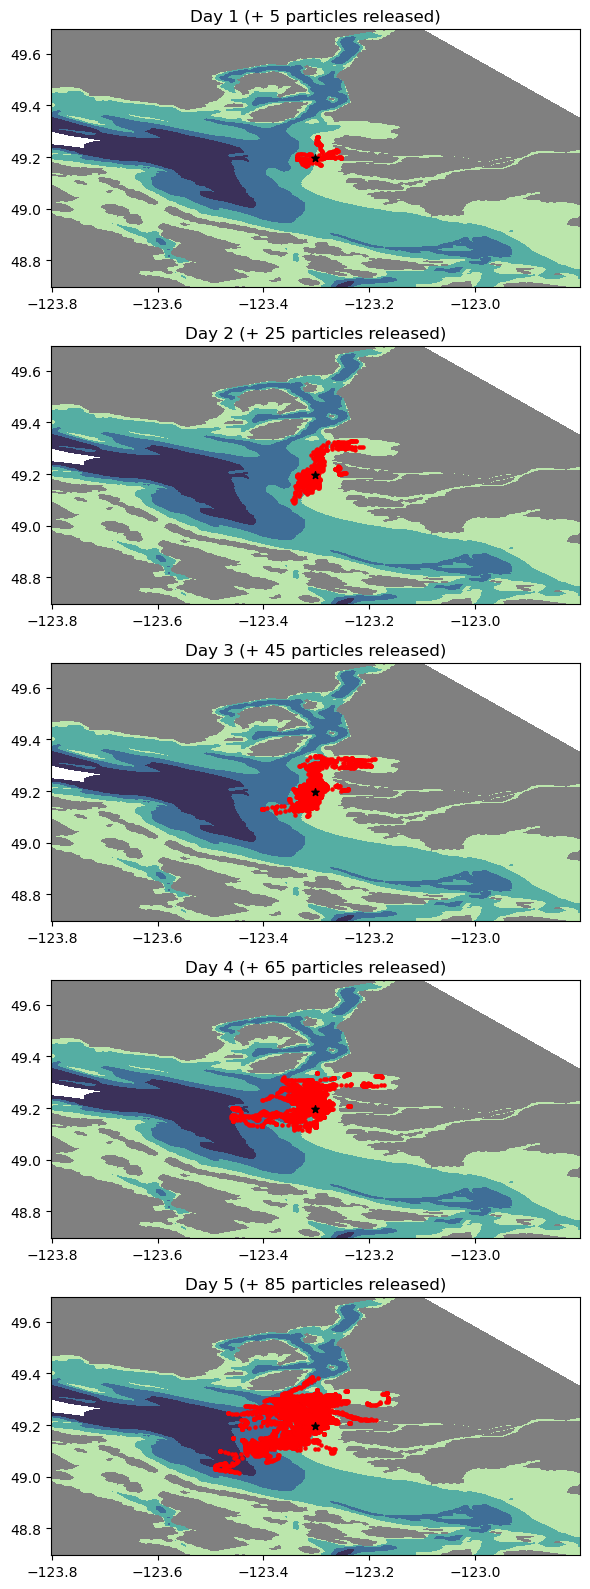

In [392]:
fig, ax = plt.subplots(5, figsize=(6,16))
blevels = list(np.arange(0,500,100))
#
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon,ds1.lat,zorder=3,c='r',s=5)
ax[0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
ax[0].set_title('Day 1 (+ ' + str(particle_counts[0]) +' particles released)')
#
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[1].scatter(ds2.lon,ds2.lat,zorder=3,c='r',s=5)
ax[1].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[1].set_ylim([clat[0]-.5,clat[0]+.5])
ax[1].set_xlim([clon[0]-.5,clon[0]+.5])
ax[1].set_title('Day 2 (+ ' + str(particle_counts[1]) +' particles released)')

#
ax[2].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[2].scatter(ds3.lon,ds3.lat,zorder=3,c='r',s=5)
ax[2].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[2].set_ylim([clat[0]-.5,clat[0]+.5])
ax[2].set_xlim([clon[0]-.5,clon[0]+.5])
ax[2].set_title('Day 3 (+ ' + str(particle_counts[2]) +' particles released)')

#
ax[3].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[3].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[3].scatter(ds4.lon,ds4.lat,zorder=3,c='r',s=5)
ax[3].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[3].set_ylim([clat[0]-.5,clat[0]+.5])
ax[3].set_xlim([clon[0]-.5,clon[0]+.5])
ax[3].set_title('Day 4 (+ ' + str(particle_counts[3]) +' particles released)')

#
ax[4].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[4].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[4].scatter(ds5.lon,ds5.lat,zorder=3,c='r',s=5)
ax[4].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[4].set_ylim([clat[0]-.5,clat[0]+.5])
ax[4].set_xlim([clon[0]-.5,clon[0]+.5])
ax[4].set_title('Day 5 (+ ' + str(particle_counts[4]) +' particles released)')
#
plt.tight_layout()

Text(0.5, 1.0, 'ALL Particles after 5 days of discharge')

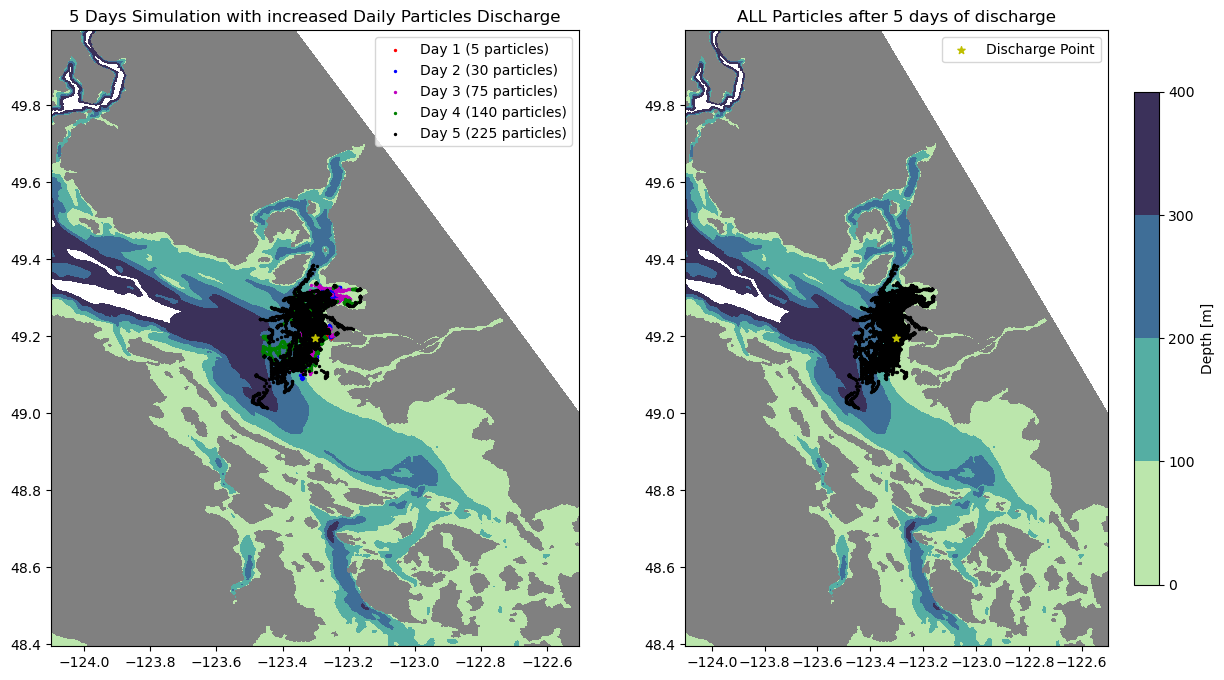

In [394]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
blevels = list(np.arange(0,500,100))
#
im =ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon,ds1.lat,zorder=3,c='r',s=2, label = 'Day 1 (' + str(len(ds1.trajectory)) + ' particles)')
ax[0].scatter(ds2.lon,ds2.lat,zorder=3,c='b',s=2, label = 'Day 2 (' + str(len(ds2.trajectory)) + ' particles)')
ax[0].scatter(ds3.lon,ds3.lat,zorder=3,c='m',s=2, label = 'Day 3 (' + str(len(ds3.trajectory)) + ' particles)')
ax[0].scatter(ds4.lon,ds4.lat,zorder=3,c='g',s=2, label = 'Day 4 (' + str(len(ds4.trajectory)) + ' particles)')
ax[0].scatter(ds5.lon,ds5.lat,zorder=3,c='k',s=2, label = 'Day 5 (' + str(len(ds5.trajectory)) + ' particles)')
ax[0].legend()
#
ax[0].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30)
ax[0].set_ylim([clat[0]-.8,clat[0]+.8])
ax[0].set_xlim([clon[0]-.8,clon[0]+.8])
#
cbar = fig.colorbar(im, ax=ax[1], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
ax[0].set_title('5 Days Simulation with increased Daily Particles Discharge')
#
#
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[1].scatter(ds1.lon,ds1.lat,zorder=3,c='k',s=2)
ax[1].scatter(ds2.lon,ds2.lat,zorder=3,c='k',s=2)
ax[1].scatter(ds3.lon,ds3.lat,zorder=3,c='k',s=2)
ax[1].scatter(ds4.lon,ds4.lat,zorder=3,c='k',s=2)
ax[1].scatter(ds5.lon,ds5.lat,zorder=3,c='k',s=2)
#
ax[1].scatter(clon[0],clat[0], zorder=3, c='y', marker='*',s=30, label = 'Discharge Point')
ax[1].set_ylim([clat[0]-.8,clat[0]+.8])
ax[1].set_xlim([clon[0]-.8,clon[0]+.8])
ax[1].legend()
#
ax[1].set_title('ALL Particles after 5 days of discharge')


Text(0.5, 1.0, '5 days of Simulation with increased Daily Particles Discharge')

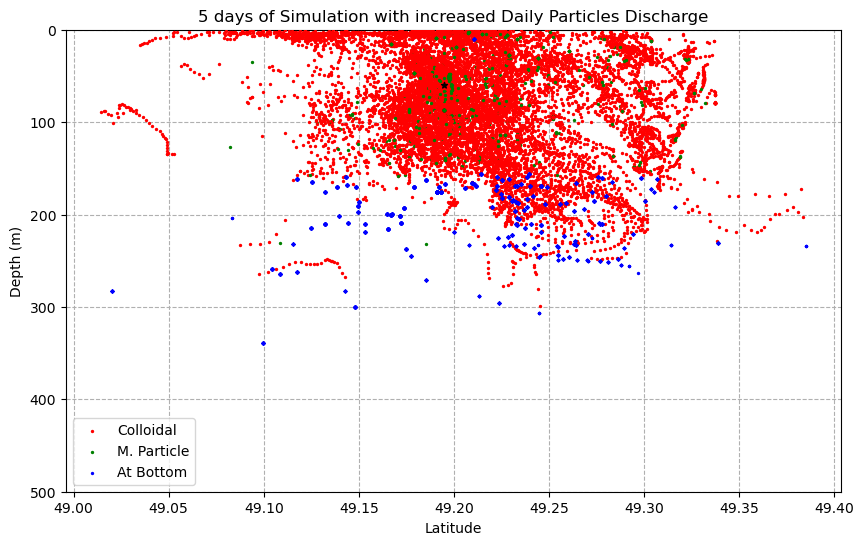

In [401]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(ds1.lat.where(ds1.status==2),depth1.where(ds1.status==2),zorder=3,c='r',s=2, label = 'Colloidal')
ax.scatter(ds1.lat.where(ds1.status==3),depth1.where(ds1.status==3),zorder=3,c='g',s=2, label = 'M. Particle')
ax.scatter(ds1.lat.where(ds1.status==4),depth1.where(ds1.status==4),zorder=3,c='b',s=2, label = 'At Bottom')
#
ax.scatter(ds2.lat.where(ds2.status==2),depth2.where(ds2.status==2),zorder=3,c='r',s=2)
ax.scatter(ds2.lat.where(ds2.status==3),depth2.where(ds2.status==3),zorder=3,c='g',s=2)
ax.scatter(ds2.lat.where(ds2.status==4),depth2.where(ds2.status==4),zorder=3,c='b',s=2)
#
ax.scatter(ds3.lat.where(ds3.status==2),depth3.where(ds3.status==2),zorder=3,c='r',s=2)
ax.scatter(ds3.lat.where(ds3.status==3),depth3.where(ds3.status==3),zorder=3,c='g',s=2)
ax.scatter(ds3.lat.where(ds3.status==4),depth3.where(ds3.status==4),zorder=3,c='b',s=2)
#
ax.scatter(ds4.lat.where(ds4.status==2),depth4.where(ds4.status==2),zorder=3,c='r',s=2)
ax.scatter(ds4.lat.where(ds4.status==3),depth4.where(ds4.status==3),zorder=3,c='g',s=2)
ax.scatter(ds4.lat.where(ds4.status==4),depth4.where(ds4.status==4),zorder=3,c='b',s=2)
#
ax.scatter(ds5.lat.where(ds5.status==2),depth5.where(ds5.status==2),zorder=3,c='r',s=2)
ax.scatter(ds5.lat.where(ds5.status==3),depth5.where(ds5.status==3),zorder=3,c='g',s=2)
ax.scatter(ds5.lat.where(ds5.status==4),depth5.where(ds5.status==4),zorder=3,c='b',s=2)
#
#
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')
#
ax.legend()
ax.grid(linestyle = '--')

ax.scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=20)
ax.set_ylim([500,0])
#
ax.set_title('5 days of Simulation with increased Daily Particles Discharge')

-States kernel is working ok; it's keeping the initial state for each particle through time.


-Process Kernel it seems to be overwriting the States Kernel, letting particles to change just between status 2 and 3


-PBDEs_forms Kernel is not affecting the other Kernels, since it's just changing a direct property of the particles, not changing their status


Text(0.5, 0.98, 'Particles from Iona Outfall Depths 2022-01-01 00:00:00 to 2022-01-30 00:00:00')

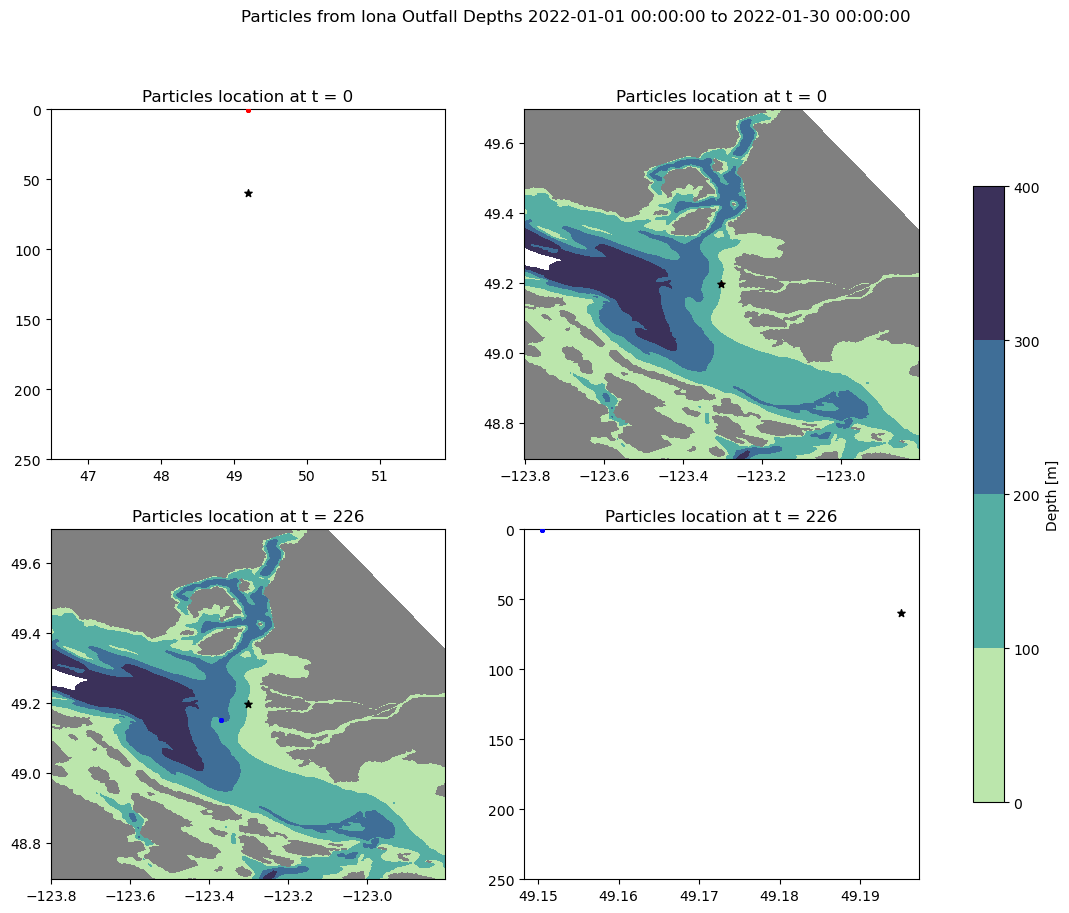

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(14,10))

axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c='r',s=5)
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))

axs[1,1].scatter(ds1.lat[:,-1],depth1[:,-1],zorder=3,c='b',s=5)
axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Particles from Iona Outfall Depths ' + str(daterange[0]) + ' to ' + str(daterange[-1]))

In [13]:
lat = ds1['lat']
lon = ds1['lon']
status = ds1['status']
depth = ds1.z*ds1.fact
#time_hr = pd.date_range(start=start, end=start+timedelta(length), freq='H')[:-1]

In [14]:
total = len(ds1.obs) * len(ds1.trajectory)
a,b = np.where(ds1.status == 2)
a1,b1 = np.where(ds1.status == 3)
a2,b2 = np.where(ds1.status == 4)

In [15]:
idx_end_status3 = np.where(ds1.status[:,-1] == 3.)[0]
idx_end_status2 = np.where(ds1.status[:,-1] == 2.)[0]
idx_end_status4 = np.where(ds1.status[:,-1] == 4.)[0]

In [98]:
len(idx_end_status3)

0

In [16]:
per_end_status2 = (len(idx_end_status2) / len(ds1.trajectory))*100
per_end_status3 = (len(idx_end_status3) / len(ds1.trajectory))*100
per_end_status4 = (len(idx_end_status4) / len(ds1.trajectory))*100

How many particles ended up as Colloids, Marine Particles and "at the Bottom"?

In [17]:
print(str(np.round(per_end_status2,3)) + r' % of the particles ended up as Colloids')
print(str(np.round(per_end_status3,3)) + r' % of the particles ended up as Marine Particles')
print(str(np.round(per_end_status4,3)) + r' % of the particles ended up at the Bottom')

4.15 % of the particles ended up as Colloids
0.0 % of the particles ended up as Marine Particles
95.85 % of the particles ended up at the Bottom


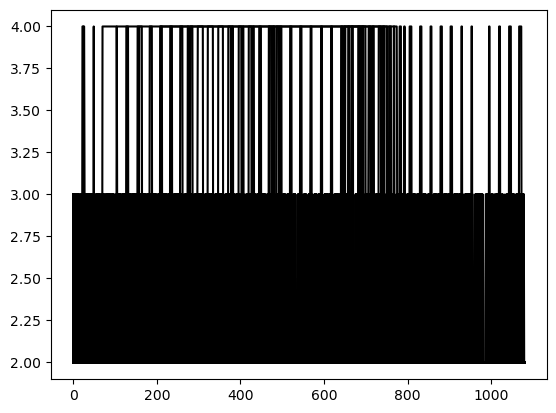

In [101]:
for i in range(len(ds1.status[idx_end_status2,:])):
    plt.plot(ds1.obs, ds1.status[idx_end_status2[i],:], 'k')
# This shows that the code is running good, particles are reaching the bottom and then getting resuspended. After this they can also reach the 
# bottom and be resuspended again. Greaaaat!!!    

In [102]:
###########check the resuspended ones .......

In [103]:
aa = np.where(ds1.status[idx_end_status2,:] == 4.)[0]
colloidal_resuspended = (len(aa) / len(idx_end_status2)) * 100
print(str(np.round((len(aa) / len(idx_end_status2)) * 100, 3)) + ' % of the Particles that ended are as colloids reached the bottom and were resuspended')
#
bb = np.where(ds1.status[idx_end_status3,:] == 4.)[0]
MP_resuspended = (len(bb) / len(idx_end_status3)) * 100
print(str(np.round((len(bb) / len(idx_end_status3)) * 100, 3)) + ' % of the Particles that ended are as marine particles reached the bottom and were resuspended')

1873.494 % of the Particles that ended are as colloids reached the bottom and were resuspended


ZeroDivisionError: division by zero

From status 2 and 3, separate the ones that ocurred after status 4. By doing this we can know which ones where resuspended!!

In [18]:
per_status2 = (len(a) / total) * 100
per_status3 = (len(a1) / total) * 100
per_status4 = (len(a2) / total) * 100

In [19]:
print('Percentage of Status 2: ' + str(per_status2))
print('Percentage of Status 3: ' + str(per_status3))
print('Percentage of Status 4: ' + str(per_status4))
#print('Percentage of Status 5: ' + str(per_status5))
#print('Percentage of Status 6: ' + str(per_status6))

Percentage of Status 2: 21.454305555555557
Percentage of Status 3: 1.049814814814815
Percentage of Status 4: 77.49587962962963


Lets first see how much particles goes through each one of the 3 status:

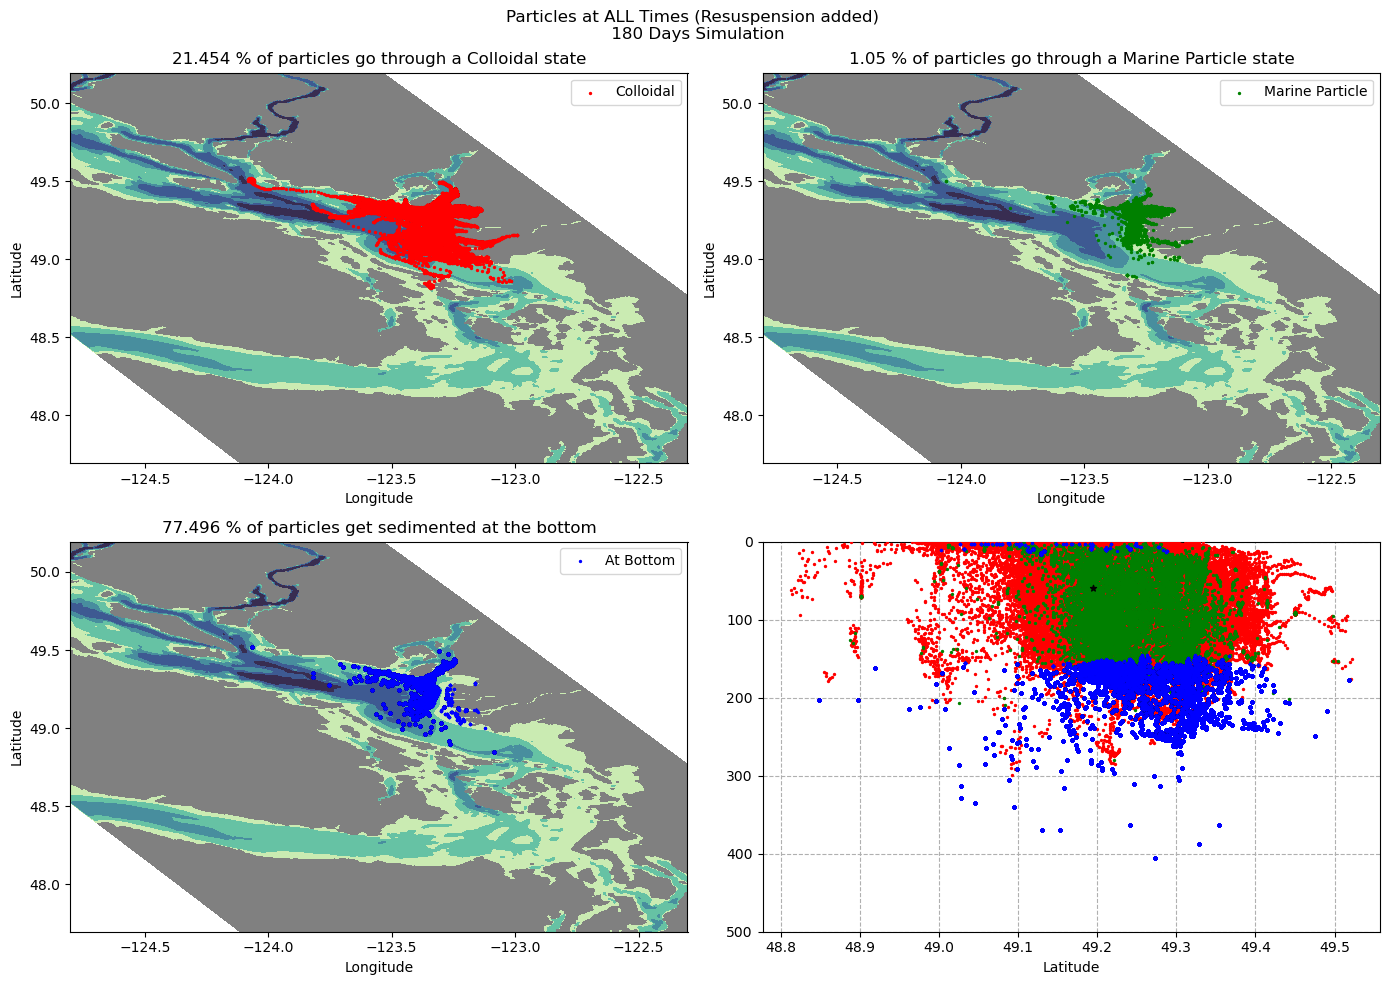

In [20]:
blevels = list(np.arange(0,600,100))
#
fig,axs=plt.subplots(2,2,figsize=(14,10))
im=axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,0].scatter(lon.where(status==2),lat.where(status==2),zorder=3,c='r',s=2, label = 'Colloidal')
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,0].legend()
axs[0,0].set_title(str(np.round(per_status2,3)) + r' % of particles go through a Colloidal state')
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')

#axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))
#
im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,1].scatter(lon.where(status==3),lat.where(status==3),zorder=3,c='g',s=2, label = 'Marine Particle')
axs[0,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,1].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,1].legend()
axs[0,1].set_title(str(np.round(per_status3,3)) + r' % of particles go through a Marine Particle state')
axs[0,1].set_xlabel('Longitude')
axs[0,1].set_ylabel('Latitude')

#
im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[1,0].scatter(lon.where(status==4),lat.where(status==4),zorder=3,c='b',s=2, label = 'At Bottom')
axs[1,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[1,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[1,0].legend()
#axs[1,0].set_title('At bottom: ' + str(np.round(per_status4,3)) + ' %' + '\n Colloidal Resuspended: ' + str(np.round(per_status5,3)) + ' %' + '\n Particulate Resuspended: ' + str(np.round(per_status6,3)) + ' %')
axs[1,0].set_title(str(np.round(per_status4,3)) + r' % of particles get sedimented at the bottom')
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
#
axs[1,1].scatter(lat.where(status==2),depth.where(status==2),zorder=3,c='r',s=2)
axs[1,1].scatter(lat.where(status==3),depth.where(status==3),zorder=3,c='g',s=2)
axs[1,1].scatter(lat.where(status==4),depth.where(status==4),zorder=3,c='b',s=2)
axs[1,1].set_xlabel('Latitude')
axs[1,1].grid(linestyle = '--')

axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=20)
axs[1,1].set_ylim([500,0])
#
#cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
#cbar.set_label('Depth [m]')
#
plt.suptitle('Particles at ALL Times (Resuspension added) \n ' + str(length) + ' Days Simulation')
#
plt.tight_layout()

In the figure above we are looking at how many times did all of the particles at ALL times went through each one of the states. So, the percentages goes like:

- The amount of particles in particle.status = 2, 3 and 4 is divided by the total amount of particles, which is (ds1.obs $\times$ ds1.trajectory) 

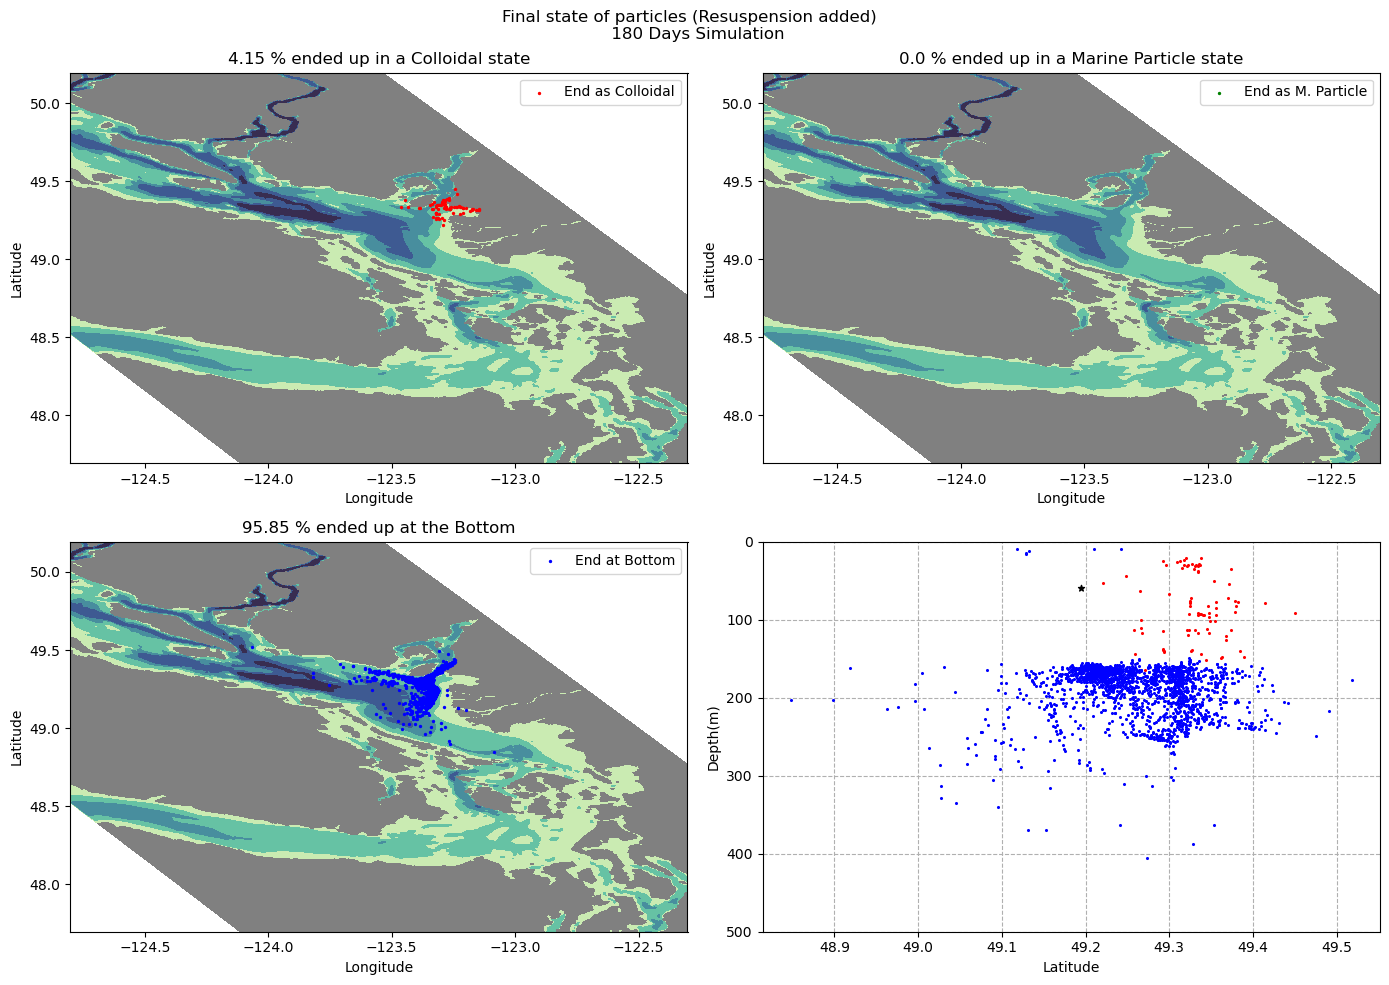

In [21]:
blevels = list(np.arange(0,600,100))
#
fig,axs=plt.subplots(2,2,figsize=(14,10))
im=axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,0].scatter(lon[idx_end_status2,-1],lat[idx_end_status2,-1],zorder=3,c='r',s=2 , label = 'End as Colloidal')
#axs[0,0].scatter(lon[aa,:],lat[aa,:],zorder=3,c='c',s=2, alpha = 0.5 , label = 'Resuspended')
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,0].legend()
axs[0,0].set_title(str(np.round(per_end_status2,3)) + r' % ended up in a Colloidal state')# + '\n' + str(np.round(colloidal_resuspended,3)) + r'% were resuspended')
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')
#axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))
#
im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,1].scatter(lon[idx_end_status3,-1],lat[idx_end_status3,-1],zorder=3,c='g',s=2, label = 'End as M. Particle')
#axs[0,1].scatter(lon[bb,:],lat[bb,:],zorder=3,c='m',s=2, alpha = 0.5 , label = 'Resuspended')
axs[0,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,1].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,1].legend()
axs[0,1].set_title(str(np.round(per_end_status3,3)) + r' % ended up in a Marine Particle state')# + '\n' + str(np.round(MP_resuspended,3)) + r'% were resuspended')
axs[0,1].set_xlabel('Longitude')
axs[0,1].set_ylabel('Latitude')

#
im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[1,0].scatter(lon[idx_end_status4,-1],lat[idx_end_status4,-1],zorder=3,c='b',s=2, label = 'End at Bottom')
axs[1,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[1,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[1,0].legend()
#axs[1,0].set_title('At bottom: ' + str(np.round(per_status4,3)) + ' %' + '\n Colloidal Resuspended: ' + str(np.round(per_status5,3)) + ' %' + '\n Particulate Resuspended: ' + str(np.round(per_status6,3)) + ' %')
axs[1,0].set_title(str(np.round(per_end_status4,3)) + r' % ended up at the Bottom')
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
#
axs[1,1].scatter(lat[idx_end_status2,-1], depth[idx_end_status2,-1],zorder=3,c='r',s=1.5)
axs[1,1].scatter(lat[idx_end_status3,-1], depth[idx_end_status3,-1],zorder=3,c='g',s=1.5)
axs[1,1].scatter(lat[idx_end_status4,-1], depth[idx_end_status4,-1],zorder=3,c='b',s=1.5)
#axs[1,1].scatter(lat[aa,:], depth[aa,:],zorder=3,c='c',s=1.5)
#axs[1,1].scatter(lat[bb,:], depth[bb,:],zorder=3,c='m',s=1.5)
axs[1,1].set_xlabel('Latitude')

axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=20)
axs[1,1].set_ylim([500,0])
axs[1,1].grid(linestyle = '--')
axs[1,1].set_ylabel('Depth(m)')
#
#cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
#cbar.set_label('Depth [m]')
#
plt.suptitle('Final state of particles (Resuspension added)  \n ' + str(length) + ' Days Simulation')
#
plt.tight_layout()


In the case of the figure above, we are looking at what is the last state that the particle went through during the simulation. This means that we are comparing:

 - ds1.status[idx, -1] for status 2, 3 and 4 is divided for the amount of particles deployed (ds1.trajectory) 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax.scatter(lon[:, 0], lat[:, 0],s=2, c='k')
ax.scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)
#ax.legend()
ax.set_ylim([clat[0]-1,clat[0]+1])
ax.set_xlim([clon[0]-1,clon[0]+1])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_title('Deployed Particles from Iona (resuspension added)')
nmin, nmax = 0, -1
#
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles', artist='Vicente',
                comment='Particles movement (Year 2022)')
writer = FFMpegWriter(fps=30, metadata=metadata)

with writer.saving(fig, path['anim']+"/run_resuspension_added.mp4", 100):
    for tm in range(len(ds1.obs)):
        s = ax.scatter(lon[:, nmin:tm], lat[:, nmin:tm],s=2, c=depth[:,nmin:tm], cmap = 'jet')
        if tm == 0:  # Adding colorbar only once
            s.set_clim(depth.min().values, depth.max().values)
            cb1 = fig.colorbar(s, ax=ax)
            cb1.set_label('Status')
        ax.set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[tm]+1))
        writer.grab_frame()

In [96]:
def update_plot(i,depth, axs):
    axs.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
    particles = axs.scatter(lon[:,i], lat[:,i], c=depth[:,i] )
    axs.set_title('Deployed Particles from Iona (resuspension added)')

In [ ]:
# Configure the Plot
fig, axs = plt.subplots( figsize=(8, 8))
axs.set_ylabel('Latitude')
axs.set_xlabel('Longitude')
axs.set_ylim([clat[0]-1,clat[0]+1])
axs.set_xlim([clon[0]-1,clon[0]+1])

ani = animation.FuncAnimation(fig, update_plot, frames=int(len(ds1.time[0])/100),
                    fargs=(depth, axs),
                    interval=100, blit=False, repeat=False) 
#
plt.close()

In [ ]:
t = 1000
#
fig,axs=plt.subplots(2,2,figsize=(14,10))

pp = axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c=ds1.status[:,0],s=5, cmap = 'jet')
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c=ds1.status[:,0],s=5, cmap = 'jet')
axs[0,1].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,t],ds1.lat[:,t],zorder=3,c=ds1.status[:,t],s=5. , cmap = 'jet')
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[t]+1))

particles = axs[1,1].scatter(ds1.lat[:,t],depth1[:,t],zorder=3,c=ds1.status[:,t],s=5, cmap = 'jet')
axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[t]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
cbar1 = fig.colorbar(pp, ax=axs, location='right', shrink=0.8)
cbar1.set_label('Status')
#
plt.suptitle('Particles from Iona Outfall Depths ' + str(daterange[0]) + ' to ' + str(daterange[-1]))

In [17]:
t = 1000

One particle plot / animation

In [175]:
a4 = np.where(ds1.status == 4)
a3 = np.where(ds1.status == 3)
a2 = np.where(ds1.status == 2)
a1 = np.where(ds1.status == 1)

In [ ]:
p_num = a1[0]
fig, ax = plt.subplots(1,2,figsize = (12,6))
#
mapita=ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon[p_num,:],ds1.lat[p_num,:],zorder=3,c=ds1.status[p_num,:],s=5. , cmap = 'jet')
ax[0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
#
single = ax[1].scatter(ds1.lat[p_num,:],depth1[p_num,:],zorder=3,c=ds1.status[p_num,:],s=5, cmap = 'jet')
ax[1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
ax[1].set_ylim([250,0])
#
cbar = fig.colorbar(mapita, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
cbar1 = fig.colorbar(single, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Status')
#

BOTTOM MAPS

In [ ]:
aa = np.where(ds1.status[:,-1] == 4)
aa[0]

In [ ]:
x, y = finder(ds1.lat[0,0].values, ds1.lon[0,0].values)
print ("The total depth at this location is", mask.totaldepth[x, y].values, 'm', 'and the particle depth is ', ds1.z[0,0].values)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
particles = ax[0].scatter(ds1.lon[aa[0], -1], ds1.lat[aa[0], -1], s=5, c=ds1.z[aa[0], -1], cmap = cmap, vmin = 0, vmax = 170)
ax[0].set_ylim([clat[0]-1.5,clat[0]+1.5])
ax[0].set_xlim([clon[0]-2.0,clon[0]+.7])
ax[0].scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)

#ax[0].set_aspect(5/4.4)
ax[0].set_title('Particles at the Bottom (Status = 4)')
#
#bathy=ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap)#,levels=blevels)
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
all_particles = ax[1].scatter(ds1.lon[:,t],ds1.lat[:,t],zorder=3,s=5, c=ds1.z[:, t], cmap = cmap, vmin = 0, vmax = 170)
ax[1].scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)
ax[1].set_ylim([clat[0]-1.5,clat[0]+1.5])
ax[1].set_xlim([clon[0]-2.0,clon[0]+.7])
ax[1].set_title(f'All Particles location at t = ' + str(ds1.time['obs'].values[t]+1))
#
cbar = fig.colorbar(particles, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Particles Depth [m]')

#
cbar1 = fig.colorbar(all_particles, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Bottom Depth [m]')


In [ ]:
print((len(ds1.z[aa[0],-1]) / len(ds1.z[:,-1])) *100, '% of Particles reach the bottom after ', length, ' days of simulation, between ' + str(daterange[0]) + ' and ' + str(daterange[-1]))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(19, 8))
im = ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon[:, 0], ds1.lat[:, 0],s=2, c='k', cmap = 'jet')
ax[1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
ax[0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
#ax.legend()
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
ax[0].set_aspect(5/4.4)
ax[1].set_ylim([250,0])
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title(str(daterange[0]) + ' to ' + str(daterange[-1]))
nmin, nmax = 0, -1
#
cbar = fig.colorbar(im, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles', artist='Vicente',
                comment='Particles movement (Year 2022)')
writer = FFMpegWriter(fps=12, metadata=metadata)

with writer.saving(fig, path['anim']+"/Year_run_PBDEs_no_POC.mp4", 100):
    for tm in range(len(ds1.obs)):
        s = ax[0].scatter(ds1.lon[:, nmin:tm], ds1.lat[:, nmin:tm],s=2, c=ds1.status[:,nmin:tm], cmap = 'jet')
        a = ax[1].scatter(ds1.lat[:,nmin:tm],depth1[:,nmin:tm],zorder=3,c=ds1.status[:,nmin:tm],s=5, cmap = 'jet')
        if tm == 0:  # Adding colorbar only once
            a.set_clim(ds1.status.min().values, ds1.status.max().values)
            cb1 = fig.colorbar(a, ax=ax[1])
            cb1.set_label('Status')
        ax[1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[tm]+1))
        writer.grab_frame()